In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

import ptitprince as pt

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from visual_behavior.data_access import loading as loading

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

In [4]:
import visual_behavior.visualization.utils as utils
import visual_behavior.data_access.utilities as utilities
import visual_behavior.ophys.response_analysis.cell_metrics as cm
import visual_behavior.visualization.ophys.platform_paper_figures as ppf

### load experiments_table from cache

In [5]:
cache_dir = loading.get_platform_analysis_cache_dir()
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)
all_expts = cache.get_ophys_experiment_table()
# print(cache_dir)

In [6]:
experiments_table = loading.get_platform_paper_experiment_table()
print(len(experiments_table))

1249


In [7]:
cells_table = loading.get_cell_table()

### get useful info

In [8]:
experience_levels = np.sort(experiments_table.experience_level.unique())
print(experience_levels)

['Familiar' 'Novel 1' 'Novel >1']


In [9]:
exposures = np.sort(experiments_table.experience_exposure.unique())
print(exposures)

['Familiar 0' 'Familiar 1' 'Familiar 2' 'Familiar 3' 'Familiar > 3'
 'Novel 0' 'Novel 1' 'Novel 2' 'Novel 3' 'Novel > 3']


In [10]:
cell_types = np.sort(experiments_table.cell_type.unique())[::-1]
print(cell_types)

['Vip Inhibitory' 'Sst Inhibitory' 'Excitatory']


In [11]:
areas = np.sort(experiments_table.targeted_structure.unique())[::-1]
print(areas)

['VISp' 'VISl']


In [12]:
depths = np.sort(experiments_table.binned_depth.unique())
print(depths)

[ 75 175 275 375]


In [13]:
layers = np.sort(experiments_table.layer.unique())[::-1]
print(layers)

['upper' 'lower']


### set events & filtering

In [14]:
interpolate = True
output_sampling_rate = 30

In [15]:
ophys_experiment_ids = experiments_table.index.values

condition = 'omissions'
stimuli = 'all_images'
session_subset = 'full_session'
data_type = 'events'

# set inclusion criteria
# options: ['full_dataset', 'active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
# inclusion_criteria = 'full_dataset'
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'

# metrics_table = get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, 
#                                                 inclusion_criteria=inclusion_criteria)
    
metrics_table = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

  0%|                                                                                          | 0/402 [00:00<?, ?it/s]

there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels


100%|████████████████████████████████████████████████████████████████████████████████| 402/402 [06:02<00:00,  1.11it/s]
C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:2530: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['condition', 'data_type', 'exception', 'filter_events', 'interpolate', 'ophys_experiment_id', 'session_subset', 'stimuli', 'use_events']]




there are 402 experiments in the returned cell_metrics table


In [16]:
if 'level_0' in metrics_table.columns: 
    metrics_table = metrics_table.drop(columns=['level_0', 'index'])
    
original_metrics_table = metrics_table.copy()

In [17]:
metrics_table = original_metrics_table.copy()

In [18]:
len(metrics_table.ophys_experiment_id.unique())

402

In [19]:
metrics_table.keys()

Index(['cell_specimen_id', 'mean_response',
       'fraction_significant_p_value_gray_screen', 'fano_factor',
       'reliability', 'running_modulation_index', 'omitted',
       'omission_response', 'pre_omitted', 'pre_omission_response',
       'omission_modulation_index', 'ophys_experiment_id', 'condition',
       'session_subset', 'stimuli', 'data_type', 'interpolate',
       'output_sampling_rate', 'response_window', 'equipment_name',
       'full_genotype', 'mouse_id', 'reporter_line', 'driver_line', 'sex',
       'age_in_days', 'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'imaging_depth', 'targeted_structure', 'date_of_acquisition',
       'session_type', 'experience_level', 'passive', 'image_set', 'file_id',
       'cell_type', 'depth', 'binned_depth', 'area_depth', 'area_binn

### how many expts have NaNs in them for the omission modulation metric

In [20]:
nan_expts = metrics_table[metrics_table.omission_modulation_index.isnull()].ophys_experiment_id.unique()
len(nan_expts)

227

In [21]:
metrics_table[metrics_table.ophys_experiment_id.isin(nan_expts)][['omission_response', 'pre_omission_response', 'omission_modulation_index']]

,omission_response,pre_omission_response,omission_modulation_index
0,0.002537,0.000678,0.578456
1,0.008300,0.003109,0.455042
2,0.000000,0.000000,NaN
3,0.010228,0.000605,0.888309
4,0.001822,0.000000,1.000000
...,...,...,...
25930,0.002584,0.021475,-0.785180
25931,0.000288,0.000216,0.143265
25932,0.000000,0.000000,NaN
25933,0.003095,0.001337,0.396628


In [22]:
expts_with_lots_of_nans = [807753334, 878363088, 940852658, 940352367]

In [23]:
for expt_id in nan_expts: 
    print(expt_id)
    print(len(metrics_table[(metrics_table.ophys_experiment_id==expt_id)]), 'total cells')
    print(len(metrics_table[(metrics_table.ophys_experiment_id==expt_id)&
                            (metrics_table.omission_modulation_index.isnull()==True)]), 'NaN cells')


795073741
45 total cells
2 NaN cells
807752719
194 total cells
1 NaN cells
808619543
196 total cells
7 NaN cells
813083478
212 total cells
4 NaN cells
807753334
286 total cells
101 NaN cells
808621034
302 total cells
30 NaN cells
809501118
200 total cells
52 NaN cells
794381992
199 total cells
11 NaN cells
795076128
221 total cells
6 NaN cells
796105304
190 total cells
9 NaN cells
826587940
29 total cells
1 NaN cells
830093338
22 total cells
2 NaN cells
833629926
161 total cells
2 NaN cells
834279496
162 total cells
1 NaN cells
842973730
136 total cells
5 NaN cells
848694639
48 total cells
2 NaN cells
847125577
151 total cells
7 NaN cells
850489605
242 total cells
4 NaN cells
851056106
233 total cells
5 NaN cells
853962969
209 total cells
12 NaN cells
850479305
120 total cells
7 NaN cells
851060467
125 total cells
8 NaN cells
852691524
127 total cells
11 NaN cells
853328115
64 total cells
12 NaN cells
853962951
49 total cells
9 NaN cells
855577488
62 total cells
7 NaN cells
878363088
5

None of the experiments are all NaNs

In [24]:
total = len(metrics_table)
nan = len(metrics_table[(metrics_table.omission_modulation_index.isnull()==True)])
nan/total

0.07075380759591286

Only 7% of all cells are NaNs, likely because they had 0 response for either omission or pre-omission

### distribution of omission modulation index

402


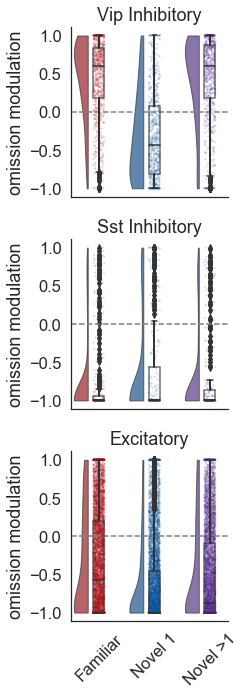

In [25]:
data = metrics_table.copy()
print(len(data.ophys_experiment_id.unique()))

metric = 'omission_modulation_index'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(3.5,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ax[i] = pt.RainCloud(data=data[data.cell_type==cell_type], hue='experience_level',
                                x='experience_level', y=metric, palette=colors,
                                 orient='v', dodge=False, rain_alpha=0.2, point_size=2, rain_jitter=0.1,
                                 bw=0.4, width_viol=0.5, width_box=0.2, alpha=0.7, ax=ax[i])
#     ax[i].legend(fontsize='xx-small', title='', bbox_to_anchor=(1,1))
    ax[i].get_legend().remove()
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('omission modulation')
    ax[i].set_xticklabels(experience_levels, rotation=45)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

### add stats

In [26]:
from scipy import stats
import statsmodels.stats.multicomp as mc

def test_significant_dropout_averages(data, metric):
    data = data[~data[metric].isnull()].copy()
    anova = stats.f_oneway(
        data.query('experience_level == "Familiar"')[metric],  
        data.query('experience_level == "Novel >1"')[metric],  
        data.query('experience_level == "Novel 1"')[metric]
        )
    comp = mc.MultiComparison(data[metric], data['experience_level'])
    post_hoc_res = comp.tukeyhsd()
    tukey_table = pd.read_html(post_hoc_res.summary().as_html(),header=0, index_col=0)[0]
    tukey_table = tukey_table.reset_index()
    mapper = {
        'Familiar':0,
        'Novel 1':1,
        'Novel >1':2,
        }
    tukey_table['x1'] = [mapper[str(x)] for x in tukey_table['group1']]
    tukey_table['x2'] = [mapper[str(x)] for x in tukey_table['group2']]
    return anova, tukey_table

In [27]:
anova, tukey_table = test_significant_dropout_averages(data, metric)

In [28]:
tukey_table

,group1,group2,meandiff,lower,upper,reject,x1,x2
0,Familiar,Novel 1,-0.3334,-0.3574,-0.3094,True,0,1
1,Familiar,Novel >1,-0.1407,-0.1651,-0.1163,True,0,2
2,Novel 1,Novel >1,0.1927,0.1689,0.2165,True,1,2


In [29]:
# def add_stats(data, metric, colors, ax):
#     """
#     function to run stats then annotate seaborn plot axes accordingly
#     status used = anova across experience levels, followed by post-hoc tukey
    
#     data: input dataframe. must have column 'experience_level' and include the provided metric
#     metric: a column of data that is being used in the plot
#     colors: color palette being used in plot
#     ax: axes handle of seaborn plot
#     """
#     from statannotations.Annotator import Annotator
    
#     # do anova across experience levels followed by post-hoc tukey
#     anova, tukey_table = test_significant_dropout_averages(data, metric)

#     # get pairs for plot annotation
#     pairs = []
#     annotation_text = []
#     for tindex, row in tukey_table.iterrows():
#         pairs.append((row.group1, row.group2))
#         if row.reject:
#             annotation_text.append('*')
#         else: 
#             annotation_text.append('ns')
#     # plot params for annotation
#     plotting_params = {'data':data, 'x':'experience_level', 'y': metric, 'palette':colors, 'size':2}
#     # annotate
#     annotator = Annotator(ax, pairs, **plotting_params)
#     annotator.set_custom_annotations(annotation_text)
#     annotator.configure(text_offset=1, verbose=0, line_height=0.05, line_offset_to_group=1, use_fixed_offset=True)
#     annotator.annotate()
    
#     return ax

In [30]:
def add_stats(data, metric, colors, ax, ymax=None):
    # do anova across experience levels followed by post-hoc tukey
    anova, tukey = test_significant_dropout_averages(data, metric)

    scale = 0.1
    fontsize = 12
    
    if ymax is None:
        ytop = ax.get_ylim()[1]
    else:
        ytop = ymax
    y1 = ytop
    y1h = ytop*(1+scale)
    y2 = ytop*(1+scale*2)
    y2h = ytop*(1+scale*3)

    if anova.pvalue<0.05:
        for tindex, row in tukey.iterrows():
            if row.x2-row.x1 > 1:
                y = y2
                yh = y2h
            else:
                y = y1
                yh = y1h 
            if row.reject:
                ax.plot([row.x1,row.x1,row.x2,row.x2],[y,yh,yh,y],'k-')
                ax.text(np.mean([row.x1,row.x2]),yh, '*', fontsize=fontsize, horizontalalignment='center', verticalalignment='bottom')
            else:
                ax.plot([row.x1,row.x1,row.x2,row.x2],[y,yh,yh,y],'k-')
                ax.text(np.mean([row.x1,row.x2]),yh, 'ns', fontsize=fontsize, horizontalalignment='center', verticalalignment='bottom')
    else:
        y = y1
        yh = y1h
        ax.plot([0,0,1,1,1,2,2], [y,yh,yh,y,yh,yh,y], 'k-')
        ax.text(.95,ytop*(1+scale*1.5), 'ns', color='k', fontsize=fontsize)
    ax.set_ylim(ymax=ytop*(1+scale*4))
    
    return ax

402
5670 is 25.0 % of all Excitatory cells


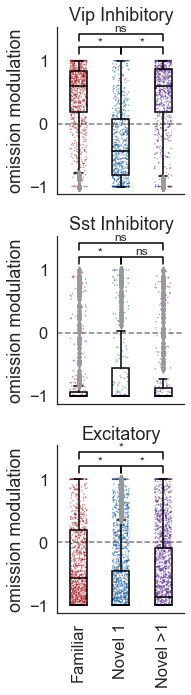

In [31]:
data = metrics_table.copy()
print(len(data.ophys_experiment_id.unique()))

metric = 'omission_modulation_index'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.boxplot(data=ct_data, width=0.4,
                                x='experience_level', y=metric, color='white', ax=ax[i], zorder=10**10)
    # format to have black lines and transparent box face
    plt.setp(ax[i].artists, edgecolor = 'k', facecolor=[0, 0, 0, 0], zorder=10**10)
    plt.setp(ax[i].lines, color='k', zorder=10**10)
    ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
    if cell_type == 'Excitatory':
        ct_data = ct_data.reset_index()
        # get 25% of all data points
        pct=0.25
        n_samples = int(len(ct_data)*pct)
        print(n_samples, 'is',pct*100,'% of all', cell_type, 'cells')
        idx = np.random.choice(np.arange(len(ct_data)), n_samples)
        # limit to this random subset
        ct_data = ct_data.loc[idx]
    ax[i] = sns.stripplot(data=ct_data, size=1.5, alpha=0.5, jitter=0.2,
                                x='experience_level', y=metric, palette=colors, ax=ax[i])
#     ax[i].legend(fontsize='xx-small', title='', bbox_to_anchor=(1,1))
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(experience_levels, rotation=90)
    ax[i].set_ylabel('omission modulation')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

No handles with labels found to put in legend.


402


No handles with labels found to put in legend.
No handles with labels found to put in legend.


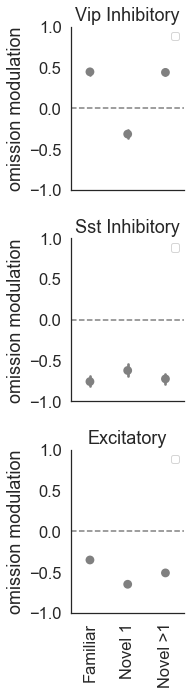

In [32]:
data = metrics_table.copy()
print(len(data.ophys_experiment_id.unique()))

metric = 'omission_modulation_index'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, dodge=0.2, join=False, x='experience_level', 
                        y=metric, color='gray', ax=ax[i])
    ax[i].legend(fontsize='xx-small', title='')
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(experience_levels, rotation=90)
    ax[i].set_ylabel('omission modulation')
    ax[i].set_ylim(-1, 1)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

### split by area

402


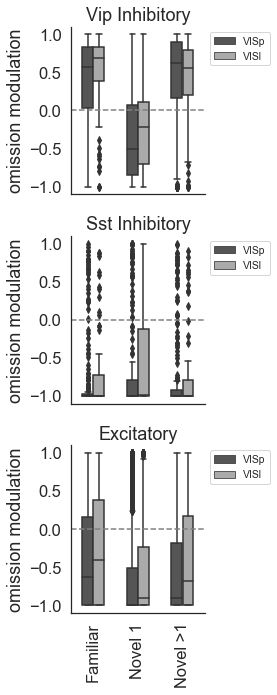

In [33]:
data = metrics_table.copy()
print(len(data.ophys_experiment_id.unique()))

metric = 'omission_modulation_index'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(4,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.boxplot(data=ct_data, width=0.5,
                                x='experience_level', hue='targeted_structure', hue_order=areas, 
                        y=metric, palette='gray', ax=ax[i])
    ax[i].legend(fontsize='xx-small', title='', bbox_to_anchor=(1,1))
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(experience_levels, rotation=90)
    ax[i].set_ylabel('omission modulation')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

402


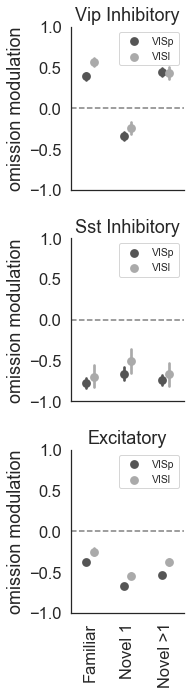

In [34]:
data = metrics_table.copy()
print(len(data.ophys_experiment_id.unique()))

metric = 'omission_modulation_index'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, dodge=0.2, join=False,
                                x='experience_level', hue='targeted_structure', hue_order=areas, 
                        y=metric, palette='gray', ax=ax[i])
    ax[i].legend(fontsize='xx-small', title='')
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(experience_levels, rotation=90)
    ax[i].set_ylabel('omission modulation')
    ax[i].set_ylim(-1, 1)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

## plots for upper vs. lower layers

261


Text(0.65, 1.02, 'V1&LM')

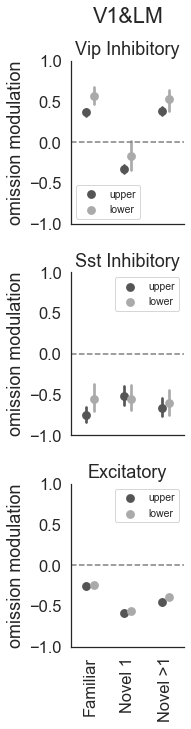

In [35]:
data = metrics_table.copy()
data = data[data.project_code=='VisualBehaviorMultiscope']
print(len(data.ophys_experiment_id.unique()))

metric = 'omission_modulation_index'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.pointplot(data=ct_data, width=0.5,join=False, dodge=0.2,
                                x='experience_level', hue='layer', hue_order=layers, 
                        y=metric, palette='gray', ax=ax[i])
    ax[i].legend(fontsize='xx-small', title='')
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_ylim(-0.5, 0.5)
    ax[i].set_xticklabels(experience_levels, rotation=90)
    ax[i].set_ylabel('omission modulation')
    ax[i].set_ylim(-1, 1)
fig.tight_layout()
fig.suptitle('V1&LM', x=0.65, y=1.02)

261


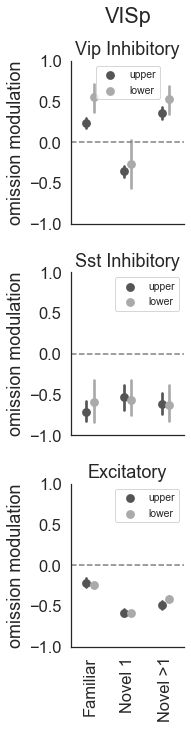

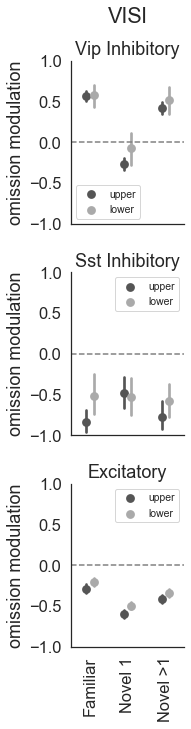

In [36]:
data = metrics_table.copy()
data = data[data.project_code=='VisualBehaviorMultiscope']

print(len(data.ophys_experiment_id.unique()))

metric = 'omission_modulation_index'

colors = utils.get_experience_level_colors()
for area in areas:
    fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
    for i,cell_type in enumerate(cell_types):
        ct_data = data[(data.cell_type==cell_type)&(data.targeted_structure==area)]
        ax[i] = sns.pointplot(data=ct_data, width=0.5, join=False, dodge=0.2,
                                    x='experience_level', hue='layer', hue_order=layers, 
                            y=metric, palette='gray', ax=ax[i])
        ax[i].legend(fontsize='xx-small', title='')
        ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
        ax[i].set_title(cell_type)
        ax[i].set_xlabel('')
        ax[i].set_ylim(-0.5, 0.5)
        ax[i].set_xticklabels(experience_levels, rotation=90)
        ax[i].set_ylabel('omission modulation')
        ax[i].set_ylim(-1, 1)
    fig.tight_layout()
    fig.suptitle(area, x=0.65, y=1.02)

### mean response by area and depth

402


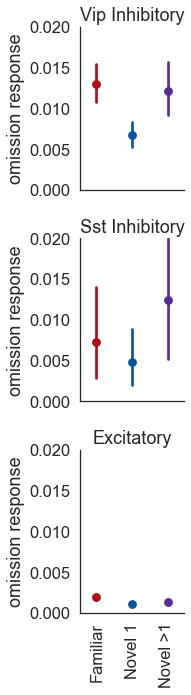

In [37]:
data = metrics_table.copy()
print(len(data.ophys_experiment_id.unique()))

metric = 'mean_response'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='experience_level', dodge=True, join=False,
                                x='experience_level', y=metric, palette=colors, ax=ax[i])
#     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
#     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
#                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
#     ax[i].legend(fontsize='xx-small', title='', bbox_to_anchor=(1,1))
    ax[i].get_legend().remove()
#     ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(experience_levels, rotation=90)
    ax[i].set_ylim(ymin=0)
    ax[i].set_ylabel('omission response')
    ax[i].set_ylim(0, 0.02)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

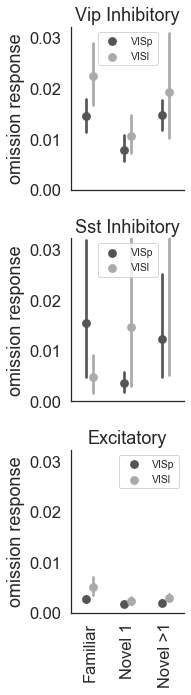

In [38]:
data = metrics_table.copy()
df = data[data.project_code=='VisualBehaviorMultiscope']

metric = 'mean_response'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = df[df.cell_type==cell_type]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='targeted_structure', hue_order=areas, 
                          dodge=0.2, join=False,
                                x='experience_level', y=metric, palette='gray', ax=ax[i])
#     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
#     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
#                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
    ax[i].legend(fontsize='xx-small', title='')
#     ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_ylim(ymin=0)
    ax[i].set_xticklabels(experience_levels, rotation=90)
    ax[i].set_ylabel('omission response')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

261


Text(0.65, 1.02, 'V1&LM')

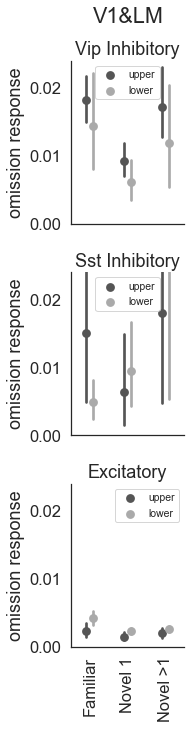

In [39]:
data = metrics_table.copy()
data = data[data.project_code=='VisualBehaviorMultiscope']
print(len(data.ophys_experiment_id.unique()))

metric = 'mean_response'

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = data[(data.cell_type==cell_type)]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='layer', hue_order=layers, 
                          join=False, dodge=0.2, 
                                x='experience_level', y=metric, palette='gray', ax=ax[i])
#     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
#     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
#                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
    ax[i].legend(fontsize='xx-small', title='',)
#     ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_ylim(ymin=0)
    ax[i].set_xticklabels(experience_levels, rotation=90)
    ax[i].set_ylabel('omission response')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
fig.suptitle('V1&LM', x=0.65, y=1.02)

261


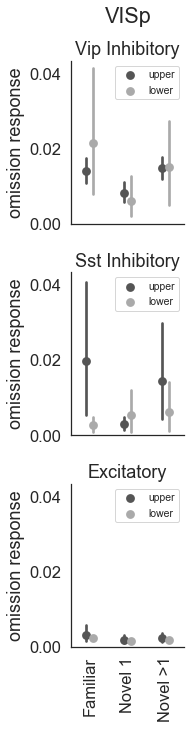

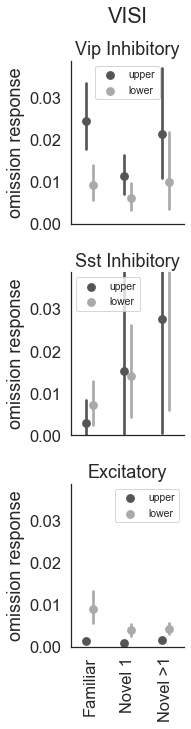

In [40]:
data = metrics_table.copy()
data = data[data.project_code=='VisualBehaviorMultiscope']
print(len(data.ophys_experiment_id.unique()))

metric = 'mean_response'

colors = utils.get_experience_level_colors()
for area in areas: 
    fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
    for i,cell_type in enumerate(cell_types):
        ct_data = data[(data.cell_type==cell_type)&(data.targeted_structure==area)]
        ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='layer', hue_order=layers, 
                                  join=False, dodge=0.2,
                                    x='experience_level', y=metric, palette='gray', ax=ax[i])
    #     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
    #     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
    #                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
        ax[i].legend(fontsize='xx-small', title='',)
    #     ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
        ax[i].set_title(cell_type)
        ax[i].set_xlabel('')
        ax[i].set_ylim(ymin=0)
        ax[i].set_xticklabels(experience_levels, rotation=90)
        ax[i].set_ylabel('omission response')
    #     ax[i].set_ylim(-1.1, 1.1)
    fig.tight_layout()
    fig.suptitle(area, x=0.65, y=1.02)

### mean change response by area and depth 

Text(0.52, 1.02, 'V1&LM')

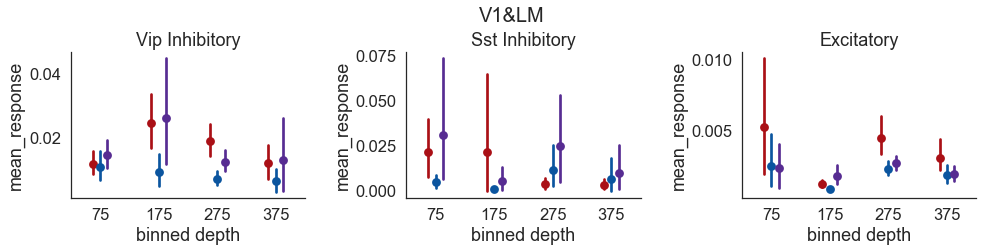

In [41]:
metric = 'mean_response'
colors = utils.get_experience_level_colors()

# for targeted_structure in np.sort(metrics_table.targeted_structure.unique()):
# df = metrics_table[metrics_table.targeted_structure==targeted_structure].copy()
df = metrics_table.copy()
df = df[df.project_code=='VisualBehaviorMultiscope']

fig, ax = plt.subplots(1,3, figsize=(14, 3.5))
for i, cell_type in enumerate(cell_types):
    ax[i] = sns.pointplot(data=df[df.cell_type==cell_type], x='binned_depth', y=metric, order=depths, join=False, ax=ax[i],
                      hue='experience_level', hue_order=experience_levels, palette=colors, width=0.5, dodge=0.25)
#     ax[i].legend(fontsize='xx-small', title='', loc='upper right')
    ax[i].get_legend().remove()
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('binned depth')
#     ax[i].set_ylim(0,0.2)
fig.tight_layout()
fig.suptitle('V1&LM', x=0.52, y=1.02, fontsize=20)

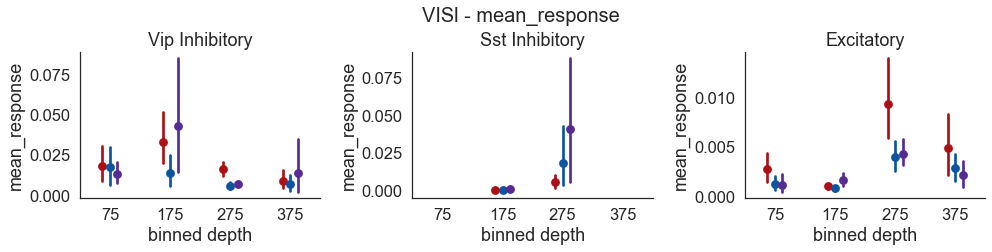

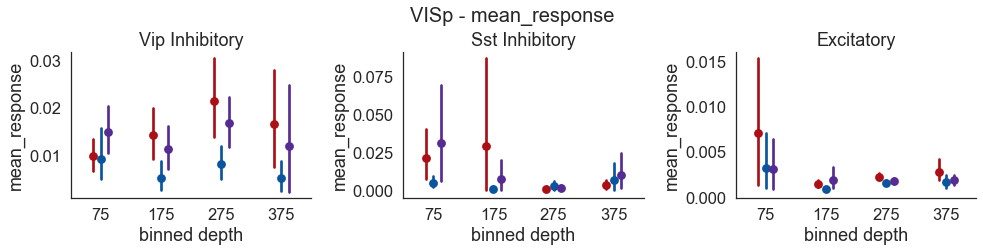

In [42]:
metric = 'mean_response'
colors = utils.get_experience_level_colors()

for targeted_structure in np.sort(metrics_table.targeted_structure.unique()):
    df = metrics_table[metrics_table.targeted_structure==targeted_structure].copy()
    df = df[df.project_code=='VisualBehaviorMultiscope']

    fig, ax = plt.subplots(1,3, figsize=(14,3.5))
    for i, cell_type in enumerate(cell_types):
        ax[i] = sns.pointplot(data=df[df.cell_type==cell_type], x='binned_depth', y=metric, order=depths, join=False, ax=ax[i],
                          hue='experience_level', hue_order=experience_levels, palette=colors, width=0.5, dodge=0.25)
#         ax[i].legend(fontsize='xx-small', title='', loc='upper right')
        ax[i].get_legend().remove()
        ax[i].set_title(cell_type)
        ax[i].set_xlabel('binned depth')
    #     ax[i].set_ylim(0,0.2)
    fig.tight_layout()
    fig.suptitle(targeted_structure + ' - '+ metric, x=0.52, y=1.02, fontsize=20)

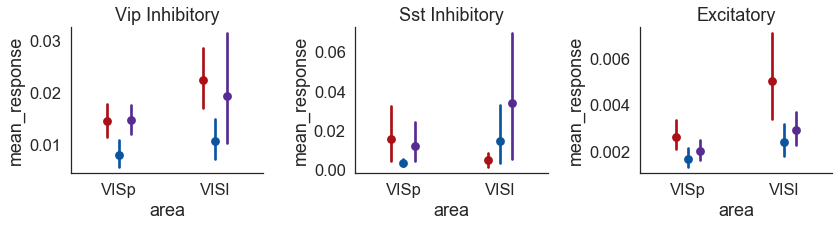

In [43]:
metric = 'mean_response'
colors = utils.get_experience_level_colors()

# for targeted_structure in np.sort(metrics_table.targeted_structure.unique()):
# df = metrics_table[metrics_table.targeted_structure==targeted_structure].copy()
df = metrics_table.copy()
df = df[df.project_code=='VisualBehaviorMultiscope']

fig, ax = plt.subplots(1,3, figsize=(12, 3.5))
for i, cell_type in enumerate(cell_types):
    ax[i] = sns.pointplot(data=df[df.cell_type==cell_type], x='targeted_structure', y=metric, order=areas, join=False, ax=ax[i],
                      hue='experience_level', hue_order=experience_levels, palette=colors, width=0.5, dodge=0.25)
#     ax[i].legend(fontsize='xx-small', title='', loc='upper right')
    ax[i].get_legend().remove()
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('area')
#     ax[i].set_ylim(0,0.2)
fig.tight_layout()
# fig.suptitle(targeted_structure + ' - '+ metric, x=0.52, y=1.02, fontsize=20)

### experience modulation of omission response

In [44]:
print(len(metrics_table.cell_specimen_id.unique()))

# get subset of data of interest
metric = 'mean_response'
metric_data = metrics_table[['cell_specimen_id', 'ophys_experiment_id', metric]]

# merge in metadata for sessions to compare
metric_data = metric_data.merge(experiments_table.reset_index()[['ophys_experiment_id', 'experience_level']], on=['ophys_experiment_id'])

# groupby cell and session number then average across multiple sessions of the same type for each cell
metric_data = metric_data.groupby(['cell_specimen_id', 'experience_level']).mean()[[metric]]
# unstack to get metric for each session number
metric_data = metric_data.unstack()
# get rid of multi index column name
metric_data.columns = metric_data.columns.droplevel(0)

# compute modulation indices
exp_level_1 = 'Familiar'

exp_level_2 = 'Novel 1'
metric_data[exp_level_2+' vs. '+exp_level_1] = (metric_data[exp_level_2]-metric_data[exp_level_1])/(metric_data[exp_level_2]+metric_data[exp_level_1])
exp_level_2 = 'Novel >1'
metric_data[exp_level_2+' vs. '+exp_level_1] = (metric_data[exp_level_2]-metric_data[exp_level_1])/(metric_data[exp_level_2]+metric_data[exp_level_1])

exp_level_2 = 'Novel 1'
metric_data[exp_level_2+' % of '+exp_level_1] = (metric_data[exp_level_2])/(metric_data[exp_level_1])
exp_level_2 = 'Novel >1'
metric_data[exp_level_2+' % of '+exp_level_1] = (metric_data[exp_level_2])/(metric_data[exp_level_1])

# add cell type
metric_data = metric_data.merge(cells_table[['cell_specimen_id', 'cell_type']], on='cell_specimen_id')

14495


In [45]:
metric_data = metric_data.drop_duplicates(subset='cell_specimen_id')

In [46]:
df = metric_data[['cell_specimen_id', 'Novel 1 vs. Familiar', 'Novel >1 vs. Familiar', 'cell_type']]
df = df.melt(id_vars=['cell_specimen_id', 'cell_type'], var_name='comparison',
             value_vars=['Novel 1 vs. Familiar', 'Novel >1 vs. Familiar'])
df.head()

,cell_specimen_id,cell_type,comparison,value
0,1086489847,Vip Inhibitory,Novel 1 vs. Familiar,0.349962
1,1086489860,Vip Inhibitory,Novel 1 vs. Familiar,-1.000000
2,1086489869,Vip Inhibitory,Novel 1 vs. Familiar,NaN
3,1086489882,Vip Inhibitory,Novel 1 vs. Familiar,NaN
4,1086489891,Vip Inhibitory,Novel 1 vs. Familiar,-1.000000


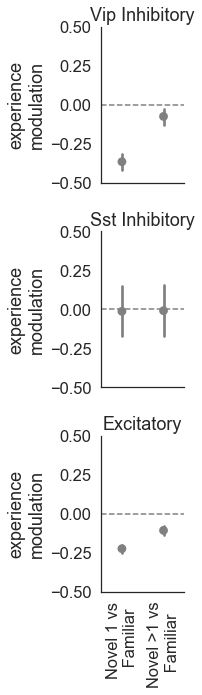

In [47]:
data = df.copy()

metric = 'value'
x = 'comparison'
xorder = np.sort(data[x].unique())

colors = utils.get_experience_level_colors()
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = data[data.cell_type==cell_type]
#     ax[i] = sns.violinplot(data=ct_data, width=0.5, cut=0, xorder=xorder,
#                                 x=x, y=metric, color='w', ax=ax[i])
    ax[i] = sns.pointplot(data=ct_data, xorder=xorder, join=False,
                                x=x, y=metric, color='gray', ax=ax[i], zorder=0)
#     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
#                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
#     ax[i].legend(fontsize='xx-small', title='', bbox_to_anchor=(1,1))
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_ylim(-0.5, 0.5)
    ax[i].set_xticklabels([x.split('.')[0]+'\n'+x.split('.')[1] for x in xorder], rotation=90)
    ax[i].set_ylabel('experience\nmodulation')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

Vip Inhibitory
Sst Inhibitory
Excitatory
6413 is 25.0 % of all Excitatory cells


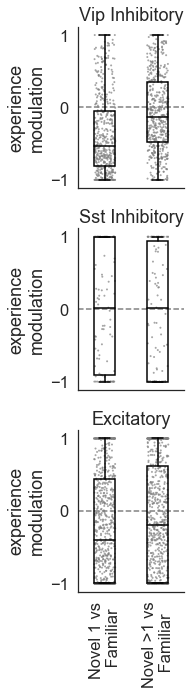

In [48]:
data = df.copy()

metric = 'value'
x = 'comparison'
xorder = np.sort(data[x].unique())

colors = utils.get_cre_line_colors()[::-1]
fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    print(cell_type)
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.boxplot(data=ct_data, width=0.4, order=xorder,
                                x=x, y=metric, color='white', ax=ax[i], zorder=10**10)
    # format to have black lines and transparent box face
    plt.setp(ax[i].artists, edgecolor = 'k', facecolor=[0, 0, 0, 0], zorder=10**10)
    plt.setp(ax[i].lines, color='k', zorder=10**10)
    # for stripplot, only show 10% of excitatory cells
    if cell_type == 'Excitatory':
        ct_data = ct_data.reset_index()
        # get 10% of all data points
        pct=0.25
        n_samples = int(len(ct_data)*pct)
        print(n_samples, 'is',pct*100,'% of all', cell_type, 'cells')
        idx = np.random.choice(np.arange(len(ct_data)), n_samples)
        # limit to this random subset
        ct_data = ct_data.loc[idx]
    ax[i] = sns.stripplot(data=ct_data, order=xorder, size=2, alpha=0.7, jitter=0.2,
                                x=x, y=metric, color='gray', ax=ax[i])
#     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
#     ax[i].legend(fontsize='xx-small', title='', bbox_to_anchor=(1,1))
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels([x.split('.')[0]+'\n'+x.split('.')[1] for x in xorder], rotation=90)
    ax[i].set_ylabel('experience\nmodulation')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

### by area and depth

Vip Inhibitory
Sst Inhibitory
Excitatory


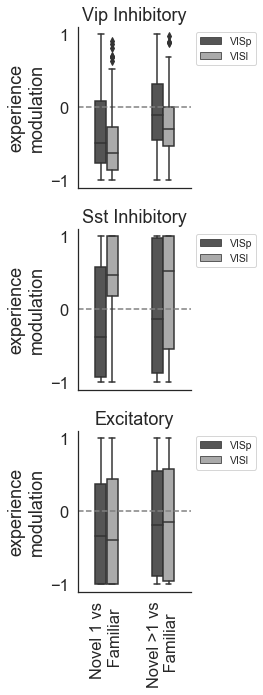

In [49]:
data = df.copy()
df = df.merge(cells_table[['cell_specimen_id', 'targeted_structure', 'binned_depth', 'project_code']])
df = df.drop_duplicates(subset=['cell_specimen_id', 'comparison'])
df = df[df.project_code=='VisualBehaviorMultiscope']

metric = 'value'
x = 'comparison'
xorder = np.sort(data[x].unique())

# colors = utils.get_cre_line_colors()[::-1]
fig, ax = plt.subplots(3,1, figsize=(4,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    print(cell_type)
    ct_data = df[df.cell_type==cell_type]
    ax[i] = sns.boxplot(data=ct_data, width=0.4, order=xorder, hue='targeted_structure', hue_order=areas,
                                x=x, y=metric, palette='gray', ax=ax[i], zorder=10**10)
    ax[i].legend(fontsize='xx-small', title='', bbox_to_anchor=(1,1))
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels([x.split('.')[0]+'\n'+x.split('.')[1] for x in xorder], rotation=90)
    ax[i].set_ylabel('experience\nmodulation')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

Vip Inhibitory
Sst Inhibitory
Excitatory


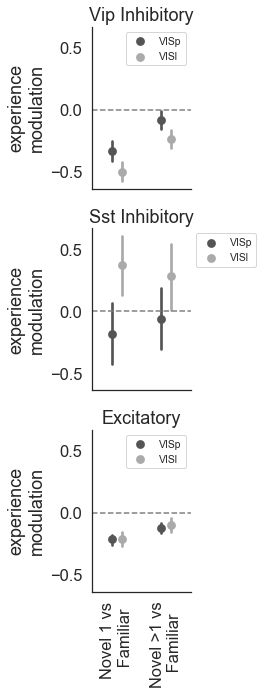

In [50]:
data = df.copy()
df = df.merge(cells_table[['cell_specimen_id', 'targeted_structure', 'binned_depth', 'project_code']])
df = df.drop_duplicates(subset=['cell_specimen_id', 'comparison'])
df = df[df.project_code=='VisualBehaviorMultiscope']

metric = 'value'
x = 'comparison'
xorder = np.sort(data[x].unique())

# colors = utils.get_cre_line_colors()[::-1]
fig, ax = plt.subplots(3,1, figsize=(4,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    print(cell_type)
    ct_data = df[df.cell_type==cell_type]
    ax[i] = sns.pointplot(data=ct_data, join=False, dodge=0.2, order=xorder, hue='targeted_structure', hue_order=areas,
                                x=x, y=metric, palette='gray', ax=ax[i], zorder=10**10)
    ax[i].legend(fontsize='xx-small', title='', bbox_to_anchor=(1,1))
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels([x.split('.')[0]+'\n'+x.split('.')[1] for x in xorder], rotation=90)
    ax[i].set_ylabel('experience\nmodulation')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)

Text(0.69, 1.02, 'V1&LM')

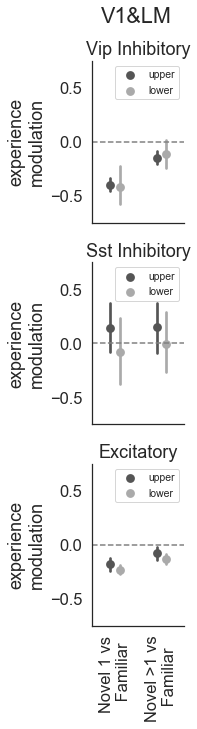

In [51]:
data = df.copy()
df = df.merge(cells_table[['cell_specimen_id', 'targeted_structure', 'layer', 'binned_depth', 'project_code']])
df = df.drop_duplicates(subset=['cell_specimen_id', 'comparison'])
df = df[df.project_code=='VisualBehaviorMultiscope']

metric = 'value'
x = 'comparison'
xorder = np.sort(data[x].unique())

fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=False)
for i,cell_type in enumerate(cell_types):
    ct_data = df[(df.cell_type==cell_type)]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='layer', hue_order=layers, dodge=0.2, join=False,
                                x=x, y=metric, palette='gray', ax=ax[i])
#     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
#     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
#                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
    ax[i].legend(fontsize='xx-small', title='')
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_ylim(-0.75, 0.75)
    ax[i].set_xticklabels([x.split('.')[0]+'\n'+x.split('.')[1] for x in xorder], rotation=90)
    ax[i].set_ylabel('experience\nmodulation')
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
fig.suptitle('V1&LM', x=0.69, y=1.02)

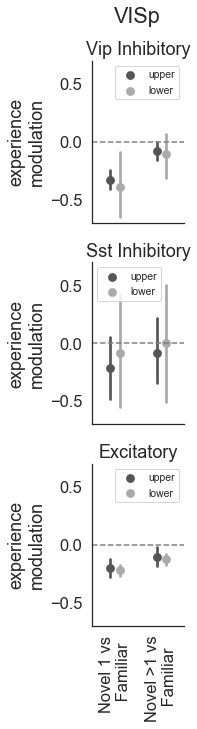

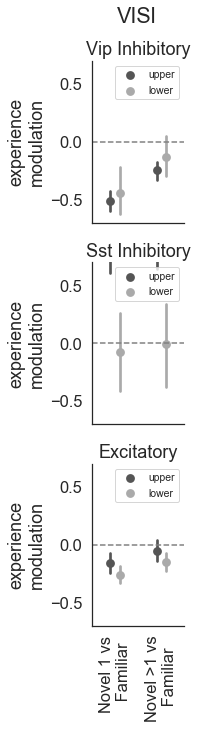

In [52]:
data = df.copy()
df = df.merge(cells_table[['cell_specimen_id', 'targeted_structure', 'binned_depth', 'layer', 'project_code']])
df = df.drop_duplicates(subset=['cell_specimen_id', 'comparison'])
df = df[df.project_code=='VisualBehaviorMultiscope']

metric = 'value'
x = 'comparison'
xorder = np.sort(data[x].unique())

for area in areas: 
    fig, ax = plt.subplots(3,1, figsize=(3,10), sharex=True, sharey=False)
    for i,cell_type in enumerate(cell_types):
        ct_data = df[(df.cell_type==cell_type)&(df.targeted_structure==area)]
        ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='layer', hue_order=layers, 
                              dodge=0.2, join=False,
                                    x=x, y=metric, palette='gray', ax=ax[i])
    #     ax[i] = add_stats(ct_data, metric, 'white', ax[i], ymax=1.1)
    #     ax[i] = sns.stripplot(data=data[data.cell_type==cell_type], size=1.5, alpha=0.5, jitter=0.2,
    #                                 x='experience_level', y=metric, palette=colors, ax=ax[i])
        ax[i].legend(fontsize='xx-small', title='')
        ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
        ax[i].set_title(cell_type)
        ax[i].set_xlabel('')
        ax[i].set_ylim(-0.75, 0.75)
        ax[i].set_xticklabels([x.split('.')[0]+'\n'+x.split('.')[1] for x in xorder], rotation=90)
        ax[i].set_ylabel('experience\nmodulation')
        ax[i].set_ylim(-0.7, 0.7)
    fig.tight_layout()
    fig.suptitle(area, x=0.69, y=1.02)

### plot as fraction of Familiar session 

In [53]:
exp_level_2 = 'Novel 1'
metric_col = exp_level_2 +' % of Familiar'
fraction_table1 = metric_data[metric_data[metric_col].isnull()==False] [['cell_specimen_id', metric_col, 'cell_type']]
fraction_table1['experience_level'] = exp_level_2
fraction_table1 = fraction_table1.rename(columns={metric_col:'% of Familiar'})

exp_level_2 = 'Novel >1'
metric_col = exp_level_2 +' % of Familiar'
fraction_table2 = metric_data[metric_data[metric_col].isnull()==False] [['cell_specimen_id', metric_col, 'cell_type']]
fraction_table2['experience_level'] = exp_level_2
fraction_table2 = fraction_table2.rename(columns={metric_col:'% of Familiar'})

fraction_table = pd.concat([fraction_table1, fraction_table2])
fraction_table = fraction_table.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])
fraction_table = fraction_table.reset_index(drop=True)
fraction_table = fraction_table.replace([np.inf, -np.inf], np.nan)

In [54]:
fraction_table

,cell_specimen_id,% of Familiar,cell_type,experience_level
0,1086489847,2.076743,Vip Inhibitory,Novel 1
1,1086489860,0.000000,Vip Inhibitory,Novel 1
2,1086489891,0.000000,Vip Inhibitory,Novel 1
3,1086490067,NaN,Excitatory,Novel 1
4,1086490073,0.408097,Excitatory,Novel 1
...,...,...,...,...
7522,1120133628,2.753953,Excitatory,Novel >1
7523,1120133649,0.266343,Excitatory,Novel >1
7524,1120133850,NaN,Excitatory,Novel >1
7525,1120134009,3.483300,Excitatory,Novel >1


### get rid of outliers

6345


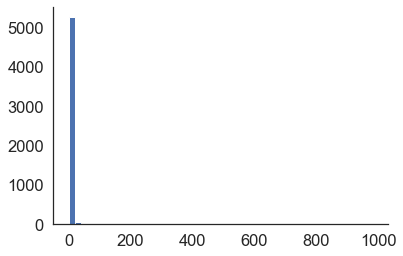

In [55]:
metric = '% of Familiar'
hist_data = fraction_table[fraction_table.cell_type=='Excitatory'][metric].values
print(len(hist_data))
plt.hist(hist_data, bins=50);

5358
7.252752644669991
5090


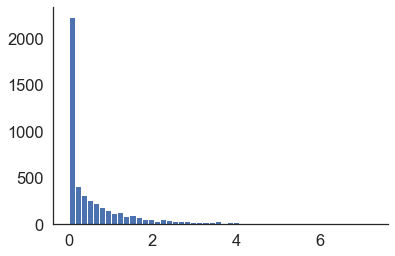

In [56]:
hist_data = fraction_table[fraction_table.cell_type=='Excitatory']
hist_data = hist_data[hist_data[metric].isnull()==False]
print(len(hist_data))
pct_95 = np.percentile(hist_data[metric].values, 95)
print(pct_95)
hist_data = hist_data[hist_data[metric]<pct_95]
print(len(hist_data))
plt.hist(hist_data[metric].values, bins=50);

969
7.060706641651706
920


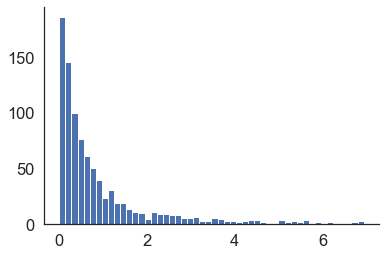

In [57]:
hist_data = fraction_table[fraction_table.cell_type=='Vip Inhibitory']
hist_data = hist_data[hist_data[metric].isnull()==False]
print(len(hist_data))
pct_95 = np.percentile(hist_data[metric].values, 95)
print(pct_95)
hist_data = hist_data[hist_data[metric]<pct_95]
print(len(hist_data))
plt.hist(hist_data[metric].values, bins=50);

140
5.7012804745720915
133


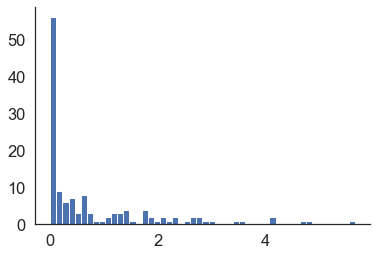

In [58]:
hist_data = fraction_table[fraction_table.cell_type=='Sst Inhibitory']
hist_data = hist_data[hist_data[metric].isnull()==False]
print(len(hist_data))
pct_95 = np.percentile(hist_data[metric].values, 95)
print(pct_95)
hist_data = hist_data[hist_data[metric]<pct_95]
print(len(hist_data))
plt.hist(hist_data[metric].values, bins=50);

6467
7.223776491179065
6143


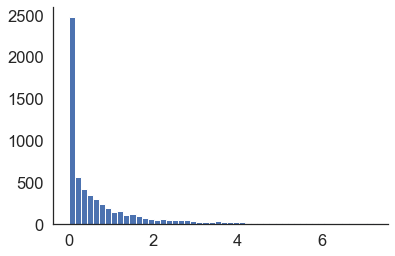

In [59]:
hist_data = fraction_table.copy()
hist_data = hist_data[hist_data[metric].isnull()==False]
print(len(hist_data))
pct_95 = np.percentile(hist_data[metric].values, 95)
print(pct_95)
hist_data = hist_data[hist_data[metric]<pct_95]
print(len(hist_data))
plt.hist(hist_data[metric].values, bins=50);

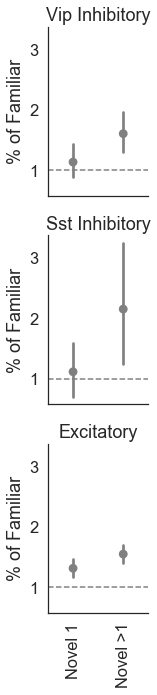

In [60]:
data = fraction_table.copy()
# remove NaNs and outliers >95th percentile
data = data[data[metric].isnull()==False]
pct_95 = np.percentile(data[metric].values, 99)
data = data[data[metric]<pct_95]
# add metadata and drop duplicates
df = data.merge(cells_table[['cell_specimen_id', 'targeted_structure', 'layer', 'binned_depth', 'project_code']])
df = df[df.project_code=='VisualBehaviorMultiscope']
df = df.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])


metric = '% of Familiar'
x = 'experience_level'
xorder = np.sort(data[x].unique())

fig, ax = plt.subplots(3,1, figsize=(2.5,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = df[(df.cell_type==cell_type)]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, join=False,
                                x=x, y=metric, color='gray', ax=ax[i])
    ax[i].axhline(y=1, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
#     ax[i].set_ylim(-0.75, 0.75)
    ax[i].set_xticklabels(xorder, rotation=90)
    ax[i].set_ylabel(metric)
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()


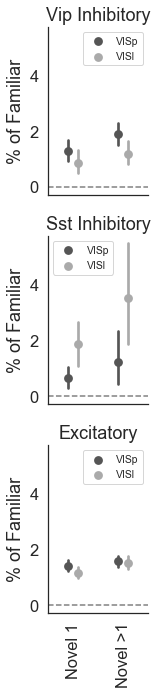

In [61]:
data = fraction_table.copy()
# remove NaNs and outliers >95th percentile
data = data[data[metric].isnull()==False]
pct_95 = np.percentile(data[metric].values, 99)
data = data[data[metric]<pct_95]
# add metadata and drop duplicates
df = data.merge(cells_table[['cell_specimen_id', 'targeted_structure', 'layer', 'binned_depth', 'project_code']])
df = df[df.project_code=='VisualBehaviorMultiscope']
df = df.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])


metric = '% of Familiar'
x = 'experience_level'
xorder = np.sort(data[x].unique())

fig, ax = plt.subplots(3,1, figsize=(2.5,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = df[(df.cell_type==cell_type)]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='targeted_structure', hue_order=areas, dodge=0.2, join=False,
                                x=x, y=metric, palette='gray', ax=ax[i])
    ax[i].legend(fontsize='xx-small', title='')
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
#     ax[i].set_ylim(-0.75, 0.75)
    ax[i].set_xticklabels(xorder, rotation=90)
    ax[i].set_ylabel(metric)
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()


Text(0.62, 1.02, 'V1&LM')

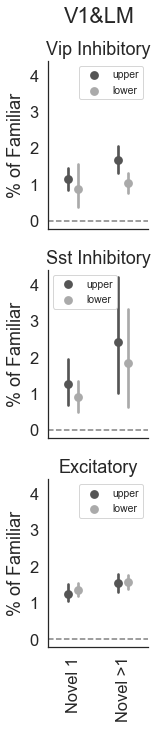

In [62]:
data = fraction_table.copy()
# remove NaNs and outliers >95th percentile
data = data[data[metric].isnull()==False]
pct_95 = np.percentile(data[metric].values, 99)
data = data[data[metric]<pct_95]
# add metadata and drop duplicates
df = data.merge(cells_table[['cell_specimen_id', 'targeted_structure', 'layer', 'binned_depth', 'project_code']])
df = df[df.project_code=='VisualBehaviorMultiscope']
df = df.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])


metric = '% of Familiar'
x = 'experience_level'
xorder = np.sort(data[x].unique())

fig, ax = plt.subplots(3,1, figsize=(2.5,10), sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = df[(df.cell_type==cell_type)]
    ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='layer', hue_order=layers, dodge=0.2, join=False,
                                x=x, y=metric, palette='gray', ax=ax[i])
    ax[i].legend(fontsize='xx-small', title='')
    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
#     ax[i].set_ylim(-0.75, 0.75)
    ax[i].set_xticklabels(xorder, rotation=90)
    ax[i].set_ylabel(metric)
#     ax[i].set_ylim(-1.1, 1.1)
fig.tight_layout()
fig.suptitle('V1&LM', x=0.62, y=1.02)

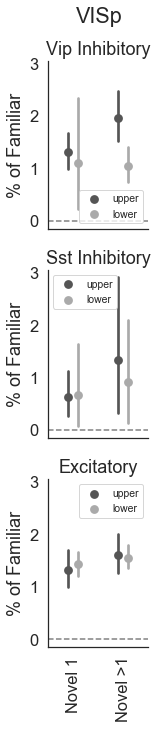

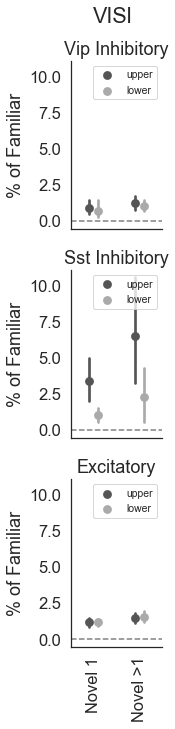

In [63]:
data = fraction_table.copy()
# remove NaNs and outliers >95th percentile
data = data[data[metric].isnull()==False]
pct_95 = np.percentile(data[metric].values, 99)
data = data[data[metric]<pct_95]
# add metadata and drop duplicates
df = data.merge(cells_table[['cell_specimen_id', 'targeted_structure', 'layer', 'binned_depth', 'project_code']])
df = df[df.project_code=='VisualBehaviorMultiscope']
df = df.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])


metric = '% of Familiar'
x = 'experience_level'
xorder = np.sort(data[x].unique())

for area in areas:
    fig, ax = plt.subplots(3,1, figsize=(2.5,10), sharex=True, sharey=True)
    for i,cell_type in enumerate(cell_types):
        ct_data = df[(df.cell_type==cell_type)&(df.targeted_structure==area)]
        ax[i] = sns.pointplot(data=ct_data, width=0.5, cut=0, hue='layer', hue_order=layers, dodge=0.2, join=False,
                                    x=x, y=metric, palette='gray', ax=ax[i])
        ax[i].legend(fontsize='xx-small', title='')
        ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
        ax[i].set_title(cell_type)
        ax[i].set_xlabel('')
    #     ax[i].set_ylim(-0.75, 0.75)
        ax[i].set_xticklabels(xorder, rotation=90)
        ax[i].set_ylabel(metric)
    #     ax[i].set_ylim(-1.1, 1.1)
    fig.tight_layout()
    fig.suptitle(area, x=0.62, y=1.02)